# 0 - Obtaining data from *journaldb*

In [1]:
import dotenv
import pendulum
from gjk.config import Settings
from gjk.models import ReadingSql
from sqlalchemy import create_engine, asc
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
from gjk.enums import TelemetryName
from gjk.first_season.beech_channels import BEECH_CHANNELS_BY_NAME
import pendulum
from typing import Dict, List
from gjk.models import ReadingSql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

timezone = "America/New_York"

# Shows IDU/ODU not matching
# start = pendulum.datetime(2024, 2, 2, 0, 0, tz=timezone)
# end = pendulum.datetime(2024, 2, 2, 23, 0, tz=timezone)
# A clean day
# start = pendulum.datetime(2024, 2, 5, 0, 0, tz=timezone)
# end = pendulum.datetime(2024, 2, 5, 23, 0, tz=timezone)

start = pendulum.datetime(2024, 2, 22, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 22, 23, 0, tz=timezone)

start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

In [2]:
ewt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'cecc9b94-9b4b-45ce-a8e9-4c63d24530aa').order_by(asc(ReadingSql.time_ms)).all()

lwt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'a49db047-e38f-44a4-b773-29102c2fc526').order_by(asc(ReadingSql.time_ms)).all()

mhp = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '94c3ab5c-7dd1-43c5-9870-733930251396').order_by(asc(ReadingSql.time_ms)).all()

odu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '498da855-bac5-47e9-b83a-a11e56a50e67').order_by(asc(ReadingSql.time_ms)).all()

idu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'beabac86-7caa-4ab4-a50b-af1ad54ed165').order_by(asc(ReadingSql.time_ms)).all()

oat = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '49db0f92-1c25-46c0-b154-4f71923ce969').order_by(asc(ReadingSql.time_ms)).all()

# 1 - Estimating heating power output

## 1.1 - EWT and LWT

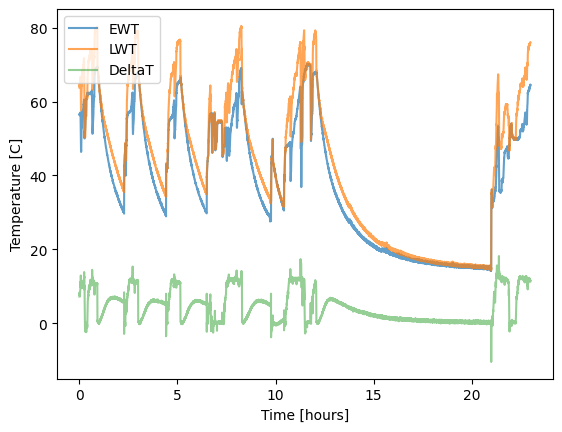

In [3]:
ewt_values = []
ewt_times = []
for e in ewt:
    if e.value > 0:
        ewt_values.append(e.value)
        ewt_times.append(e.time_ms)
ewt_times = [(x-ewt_times[0])/1000/60/60 for x in ewt_times]
ewt_values = [x/1000 for x in ewt_values]

lwt_values = []
lwt_times = []
for l in lwt:
    if l.value > 0:
        lwt_values.append(l.value)
        lwt_times.append(l.time_ms)
lwt_times = [(x-lwt_times[0])/1000/60/60 for x in lwt_times]
lwt_values = [x/1000 for x in lwt_values]

oat_values = []
oat_times = []
for o in oat:
    oat_values.append(o.value)
    oat_times.append(o.time_ms)
oat_times = [(x-oat_times[0])/1000/60/60 for x in oat_times]
oat_values = [x/1000 for x in oat_values]

df_ewt = pd.DataFrame({'time': ewt_times, 'ewt': ewt_values})
df_lwt = pd.DataFrame({'time': lwt_times, 'lwt': lwt_values})
df_ewt = df_ewt.sort_values('time')
df_lwt = df_lwt.sort_values('time')

# Merge on time and compute delta_t
df_ewt_lwt = pd.merge_asof(df_lwt, df_ewt, on='time')
df_ewt_lwt['delta_t'] = df_ewt_lwt['lwt'] - df_ewt_lwt['ewt']

plt.plot(df_ewt_lwt.time, df_ewt_lwt.ewt, alpha=0.7, label='EWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.lwt, alpha=0.7, label='LWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.delta_t, alpha=0.5, label="DeltaT")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [C]')
plt.legend(loc='upper left')
#plt.xlim([7.8, 9.9])
plt.show()

## 1.2 - Flow rate

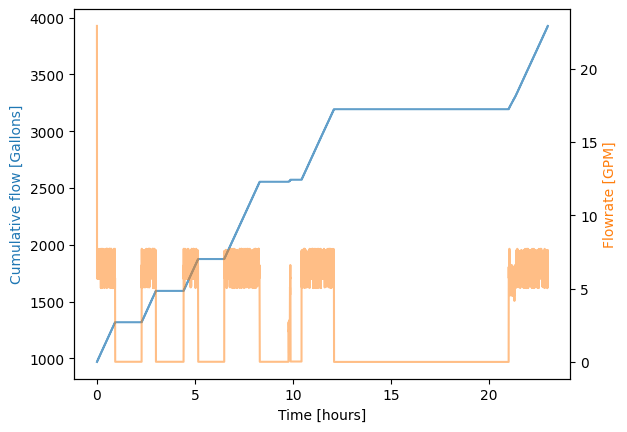

In [4]:
# Cumulative gallons
gallons_values = []
gallons_times = []
for m in mhp:
    gallons_values.append(m.value/100)
    gallons_times.append(m.time_ms)
gallons_times = [(x-gallons_times[0])/1000/60/60 for x in gallons_times]

# Convert to gpm
flow_values = []
flow_times = []

gallons_now = gallons_values[0]
time_now = gallons_times[0]

for i in range(len(gallons_values)):

    if gallons_values[i] > gallons_now:

        gpm = (gallons_values[i]-gallons_now)/(60*(gallons_times[i]-time_now))
        flow_values.append(gpm)
        flow_times.append(time_now)

        gallons_now = gallons_values[i]
        time_now = gallons_times[i]

# If the last cumulative gallons is the same as the last update (no flow since last point)
if gallons_values[-1] == gallons_now:
    flow_values.append(0)
    flow_times.append(time_now)

df_flowrate = pd.DataFrame({'time':flow_times, 'flowrate':flow_values})
df_flowrate = df_flowrate.sort_values('time')
df_ewt_lwt = df_ewt_lwt.sort_values('time')

# Merge on time with temperature values
df_heatpower = pd.merge_asof(df_ewt_lwt, df_flowrate, on='time')

fig, ax = plt.subplots(1,1)
ax.plot(gallons_times, gallons_values, alpha=0.7)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cumulative flow [Gallons]', color='tab:blue')
ax2 = ax.twinx()
ax2.plot(df_heatpower.time, df_heatpower.flowrate, alpha=0.5, color='tab:orange')
ax2.set_ylabel('Flowrate [GPM]', color='tab:orange')
plt.show()

## 1.3 - Heating power ouput

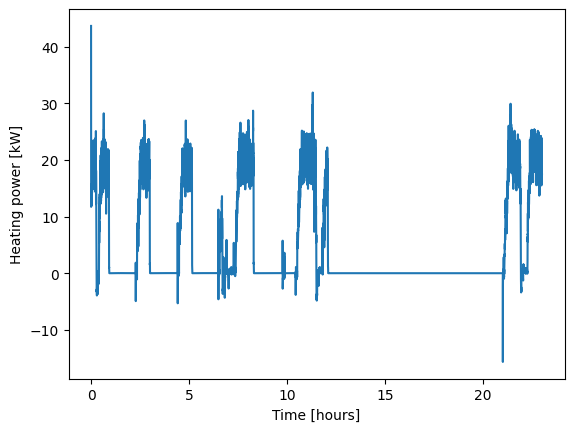

In [5]:
df_heatpower['Q_HP'] = (3.78541 * df_heatpower.flowrate / 60) * 4187 * df_heatpower.delta_t / 1000

plt.plot(df_heatpower.time, df_heatpower.Q_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Heating power [kW]')
plt.show()

# 2 - Estimating electrical power input

Data length before resampling: 4801, after resampling: 82725


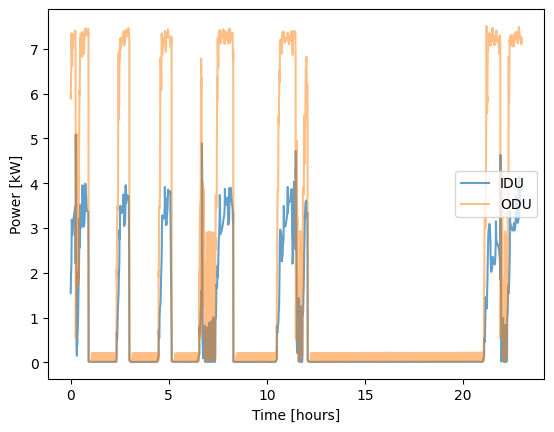

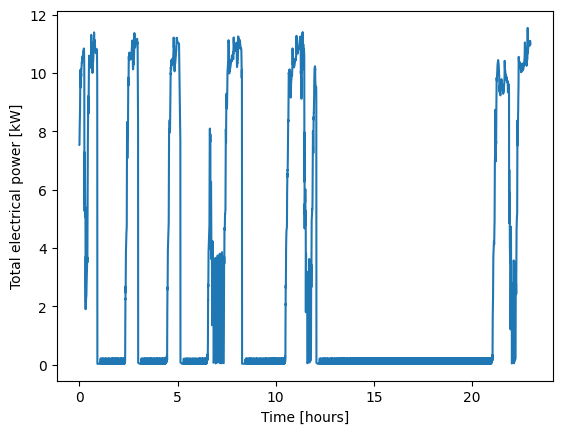

In [6]:
idu_values = []
idu_times = []
for x in idu:
    if x.value > 0:
        idu_values.append(x.value/1000)
        idu_times.append(x.time_ms)
idu_times = [(x-idu_times[0])/1000/60/60 for x in idu_times]

odu_values = []
odu_times = []
for x in odu:
    if x.value > 0:
        odu_values.append(x.value/1000)
        odu_times.append(x.time_ms)
odu_times = [(x-odu_times[0])/1000/60/60 for x in odu_times]

df_idu = pd.DataFrame({'time':idu_times, 'idu':idu_values})
df_odu = pd.DataFrame({'time':odu_times, 'odu':odu_values})
df_idu = df_idu.sort_values('time')
df_odu = df_odu.sort_values('time')

df_odu['time'] = pd.to_datetime(df_odu['time']*3600, unit='s')
df_idu['time'] = pd.to_datetime(df_idu['time']*3600, unit='s')
df_odu.set_index('time', inplace=True)
df_idu.set_index('time', inplace=True)

# Resample both DataFrames to a common frequency (e.g., 1 second)
df_odu_resampled = df_odu.resample('s').mean().interpolate()
df_idu_resampled = df_idu.resample('s').mean().interpolate()

# Merge using merge_asof on the resampled DataFrames
df_elecpower = pd.merge_asof(df_odu_resampled, df_idu_resampled, on='time', direction='backward')
df_elecpower['time'] = (df_elecpower['time'] - df_elecpower['time'].min()).dt.total_seconds() / 3600
df_elecpower['W_HP'] = df_elecpower.idu + df_elecpower.odu

print(f"Data length before resampling: {len(odu_times)}, after resampling: {len(df_elecpower)}")

plt.plot(df_elecpower.time, df_elecpower.idu, alpha=0.7, label='IDU')
plt.plot(df_elecpower.time, df_elecpower.odu, alpha=0.5, label='ODU')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()
plt.show()

plt.plot(df_elecpower.time, df_elecpower.W_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Total electrical power [kW]')
plt.show()

# 3 - Estimating COP

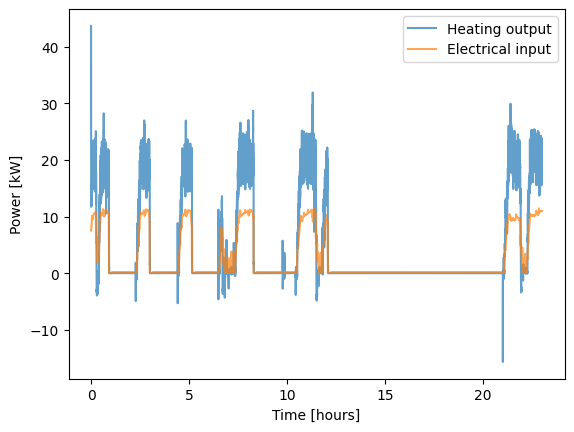

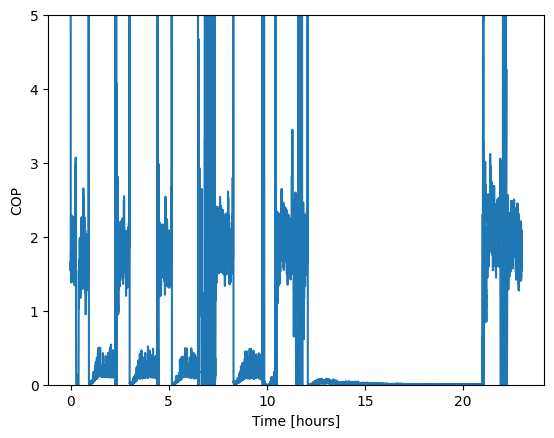

In [7]:
# Merge elec power and heating power
final = pd.merge_asof(df_heatpower, df_elecpower, on='time')
final['COP'] = final.Q_HP/final.W_HP

plt.plot(final.time, final.Q_HP, alpha=0.7, label='Heating output')
plt.plot(final.time, final.W_HP, alpha=0.7, label='Electrical input')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()
plt.show()

plt.plot(final.time, final.COP)
plt.xlabel('Time [hours]')
plt.ylabel('COP')
plt.ylim([0,5])
plt.show()

# 4 - Adding outside air temperature

In [8]:
try:
    from weather import get_temp
    oat = []
    for hour in range(int((end-start).total_hours())):
        print(f"Finding weather at {start.add(hours=hour)}...")
        oat.append(get_temp(start.add(hours=hour)))
except:
    print("Couldn't get Herbie weather for all points")
    oat = []

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/thomas/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯

Finding weather at 2024-02-22 00:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-22 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/Users/thomas/data/hrrr/20240222]
Finding weather at 2024-02-22 01:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-22 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-22 02:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-22 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-22 03:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-22 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-22 04:00:00-05:00.

In [9]:
# Add the herbie OAT
if oat:
    hour_bins = [-1]+list(range(1,int(max(final.time))+2,1))
    final['oat_herbie'] = pd.cut(final['time'], bins=hour_bins, labels=oat, ordered=False)

# Add the gridworks OAT
df_oat = pd.DataFrame({'time': oat_times, 'oat': oat_values})
final = pd.merge_asof(final, df_oat, on='time')
final = final.round(3)

# Bring back to datetime
initial_time = start_ms/1000
final['time_dt'] = final.time*3600 + initial_time
final['time_dt'] = pd.to_datetime(final['time_dt'], unit='s')

if 'oat_herbie' in final.columns:
    final = final[['time_dt', 'time', 'oat', 'oat_herbie', 'ewt', 'lwt', 'delta_t', 'flowrate', 'odu', 'idu', 'Q_HP', 'W_HP', 'COP']]
else:
    final = final[['time_dt', 'time', 'oat', 'ewt', 'lwt', 'delta_t', 'flowrate', 'odu', 'idu', 'Q_HP', 'W_HP', 'COP']]

display(final)

,time_dt,time,oat,oat_herbie,ewt,lwt,delta_t,flowrate,odu,idu,Q_HP,W_HP,COP
0,2024-02-22 05:00:00.000000000,0.000,-6.268,-3.53,56.548,63.768,7.220,22.910,5.992,1.550,43.694,7.542,5.793
1,2024-02-22 05:00:07.200000048,0.002,-7.328,-3.53,56.284,64.039,7.755,7.637,5.942,1.609,15.646,7.551,2.072
2,2024-02-22 05:00:07.200000048,0.002,-6.416,-3.53,56.536,64.343,7.807,7.637,5.932,1.642,15.751,7.573,2.080
3,2024-02-22 05:00:10.799999952,0.003,-7.095,-3.53,56.536,64.024,7.488,7.637,5.928,1.652,15.107,7.579,1.993
4,2024-02-22 05:00:14.400000095,0.004,-7.095,-3.53,56.536,64.289,7.753,5.726,5.917,1.681,11.726,7.598,1.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14565,2024-02-23 03:59:31.200000048,22.992,-0.349,-0.68,64.587,76.069,11.482,5.720,7.144,3.854,17.348,10.998,1.577
14566,2024-02-23 03:59:34.799999952,22.993,-0.852,-0.68,64.587,75.815,11.228,5.720,7.144,3.854,16.965,10.998,1.543
14567,2024-02-23 03:59:38.400000095,22.994,-0.852,-0.68,64.359,76.080,11.721,5.673,7.144,3.854,17.564,10.998,1.597
14568,2024-02-23 03:59:42.000000000,22.995,-1.032,-0.68,64.383,75.738,11.355,5.673,7.144,3.854,17.016,10.998,1.547


# 5 - Saving CSVs

In [10]:
from ipywidgets import FloatSlider, interactive, Checkbox

def crop(min_time, max_time, save):

    df_crop = final.copy()
    df_crop = df_crop[df_crop.time > min_time]
    df_crop = df_crop[df_crop.time < max_time]
    
    # Create file name
    timestamp = int(list(df_crop.time_dt)[0].timestamp())
    csv_name = f"{timestamp}_lwt{round(np.mean(df_crop.lwt))}_oat{round(list(df_crop.oat)[0])}.csv".replace('-', 'neg')
    #print(csv_name)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(df_crop.time, df_crop.Q_HP, alpha=0.7, label='Heat')
    ax1.plot(df_crop.time, df_crop.W_HP, alpha=0.7, label='Elec')
    ax1.plot(df_crop.time, df_crop.lwt, alpha=0.7, label='LWT')
    ax1.plot(df_crop.time, df_crop.ewt, alpha=0.7, label='EWT')
    ax1.plot(df_crop.time, df_crop.oat, alpha=0.7, label='OAT')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Time [hours]')
    ax2.plot(df_crop.time, df_crop.COP)
    ax2.set_xlabel('Time [hours]')
    ax2.set_ylabel('COP')
    ax2.set_ylim([0, 5])
    ax1.set_title(csv_name)
    plt.tight_layout()
    if save:
        if len(df_crop) < 1000:
            plt.savefig(f"data/{csv_name.replace('.csv','.png')}")
            df_crop['time'] = df_crop['time_dt'].astype('int64') 
            df_crop['time'] = (df_crop['time'] - list(df_crop['time'])[0]) / 1e9
            df_crop.to_csv(f'data/{csv_name}')
            print(f"Saved {csv_name}")
        else:
            print("Too long")
    plt.show()

    display(df_crop.head())

# Create sliders for min and max time
min_slider = FloatSlider(value=final['time'].min(), min=final['time'].min(), max=final['time'].max(), step=0.01, description='min')
max_slider = FloatSlider(value=final['time'].max(), min=final['time'].min(), max=final['time'].max(), step=0.01, description='max')
save_checkbox = Checkbox(value=False, description='Save')

interactive(crop, min_time=min_slider, max_time=max_slider, save=save_checkbox)


interactive(children=(FloatSlider(value=0.0, description='min', max=22.996, step=0.01), FloatSlider(value=22.9…

# 6 - Regression

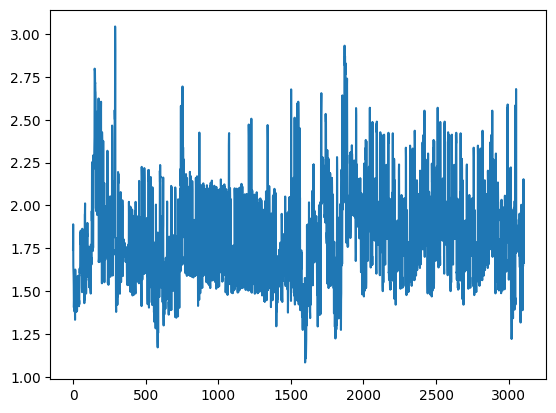

In [31]:
import os

big_df = pd.DataFrame()

for file in os.listdir('data/'):
    if '.csv' in file:
        df = pd.read_csv(f'data/{file}')
        df.drop(columns=['time', 'Unnamed: 0'], inplace=True)
        big_df = pd.concat([big_df, df], ignore_index=True) 

plt.plot(big_df.COP)
plt.show()